In [2]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import scipy
import scipy.stats as ss
import random
import seaborn as sns
import pandas as pd
import emcee
import corner

In [3]:
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/home/saurabhs/Documents/gopi/Saras_Model/saras3_S11_200mm_above_water.s1p", skiprows=5))

d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]
c=3*10**8  # speed of light (m/s)
freq=[d[i][0] for i in range(len(d)-1)] #frequency
df=pd.read_csv('/home/saurabhs/Documents/gopi/Saras_Model/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()
#print(len(rlc),len(freq))

In [4]:
def Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    l=l
    freq= [d[i][0] for i in range(len(d)-1)]
    for i in range(len(freq)):
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

In [5]:
def Compute_Tmeas_RLC_exp(PA, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    global rlc
    freq= [d[i][0] for i in range(len(d)-1)]
    gamma_A=rlc
    for i in range(len(freq)):
        #print(gamma_A[i])
        #gamma_A=p0*1e-48* freq[i] ** (N - 1) + p1*1e-39* freq[i] ** (N - 2) + p2*1e-31* freq[i] ** (N - 3) + p3*1e-23* freq[i] ** (N - 4) + p4*1e-15* freq[i] ** (N - 5) + p5*1e-08* freq[i] ** (N - 6) + p6*1e-01
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A[i])**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A[i])**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A[i])**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A[i])**2)*C))
    return(Tmeas)

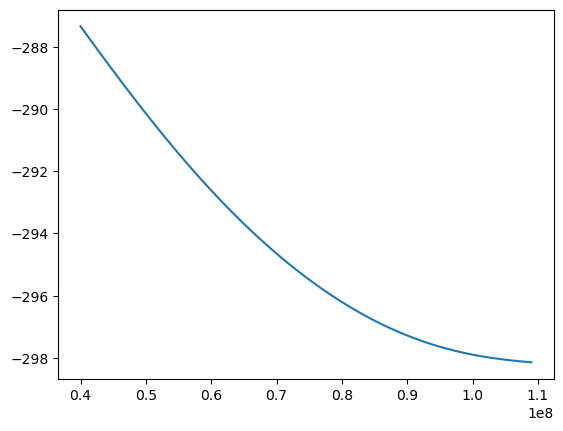

In [6]:
#print(Compute_Tmeas_RLC_exp(0,70,0.3,0.1,1))
plt.plot(freq, Compute_Tmeas_RLC_exp(0,70,0.3,0.1,0.15))

In [7]:
def Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    freq= [d[i][0] for i in range(len(d)-1)]
    for i in range(len(freq)):
        gamma_A=p0*1e-48* freq[i] ** (N - 1) + p1*1e-39* freq[i] ** (N - 2) + p2*1e-31* freq[i] ** (N - 3) + p3*1e-23* freq[i] ** (N - 4) + p4*1e-15* freq[i] ** (N - 5) + p5*1e-08* freq[i] ** (N - 6) + p6*1e-01
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

# MCMC for Open

In [8]:
########## Define the log-likelihood function
def log_likelihood_o(params,**kwargs):
    ip_params=kwargs["ip_params"]
    seed=kwargs["seed"]
    s = kwargs["s"]  # Uncertainty
    
    PA, gamma_A, PN, gamma_N, f, l = params
    
    # Define the Expected TA values
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_(*ip_params) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA
    TA_model = Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f,  l)
    TA_model=np.array(TA_model)

    # Compute chi-squared with weights
    
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)  # Likelihood function

########## Define the log-prior function
def log_prior_o(params):
    
    PA, gamma_A, PN, gamma_N, f, l = params

    if ((0 <= gamma_A <= 1) and (0 <= gamma_N <= 1) and (0<=PA<=3) and (50<=PN<=150) and (0.05<=f<=0.5) and (0.05<l<2)) : 
            return 0.0  # Reject sample
    return -np.inf # Uniform prior

######### Define the full log-probability function

def log_probability_o(params,**kwargs):
    lp = log_prior_o(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_o(params,**kwargs)

########### MCMC

def evolve_MCMC_o(**kwargs):# Define parameter names
    parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]

    # Number of walkers and steps
    ndim = 6  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(kwargs["initial_value"])
    
    ## Starting positions for the walkers
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    
    pos= initial_value[None,:] + initial_value*1e-2*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 

    def wrap_log_probability_o(params):
        return log_probability_o(params,**kwargs)
        
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability_o, threads=10)
    print(sampler.acceptance_fraction) #Mean Acceptance Ration
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples_o=sampler.get_chain()

    samples_o = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes_o = np.array([log_likelihood_o(p, **kwargs) for p in samples_o])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes_o)
    
    ########## Get the best-fit parameters
    best_fit_params_o = samples_o[max_likelihood_index].tolist()

    return full_samples_o,samples_o,best_fit_params_o

In [9]:
#evolve MCMC
ip_params=[0,1,70,0.3,0.1,0.15] #input parameters
nsteps=3000
initials=[0.007,0.97,70.7,0.29,0.1,0.13]
s=0.001
seed=59
kwargs={"s":s,"seed":seed, "nsteps":nsteps, "ip_params":ip_params, "initial_value":initials}
full_samples_o, samples_o, best_fit_params_o= evolve_MCMC_o(**kwargs)

/home/saurabhs/anaconda3/envs/saras/lib/python3.11/site-packages/emcee/ensemble.py:542: RuntimeWarning: invalid value encountered in divide
  return self.backend.accepted / float(self.backend.iteration)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [11:35<00:00,  4.31it/s]


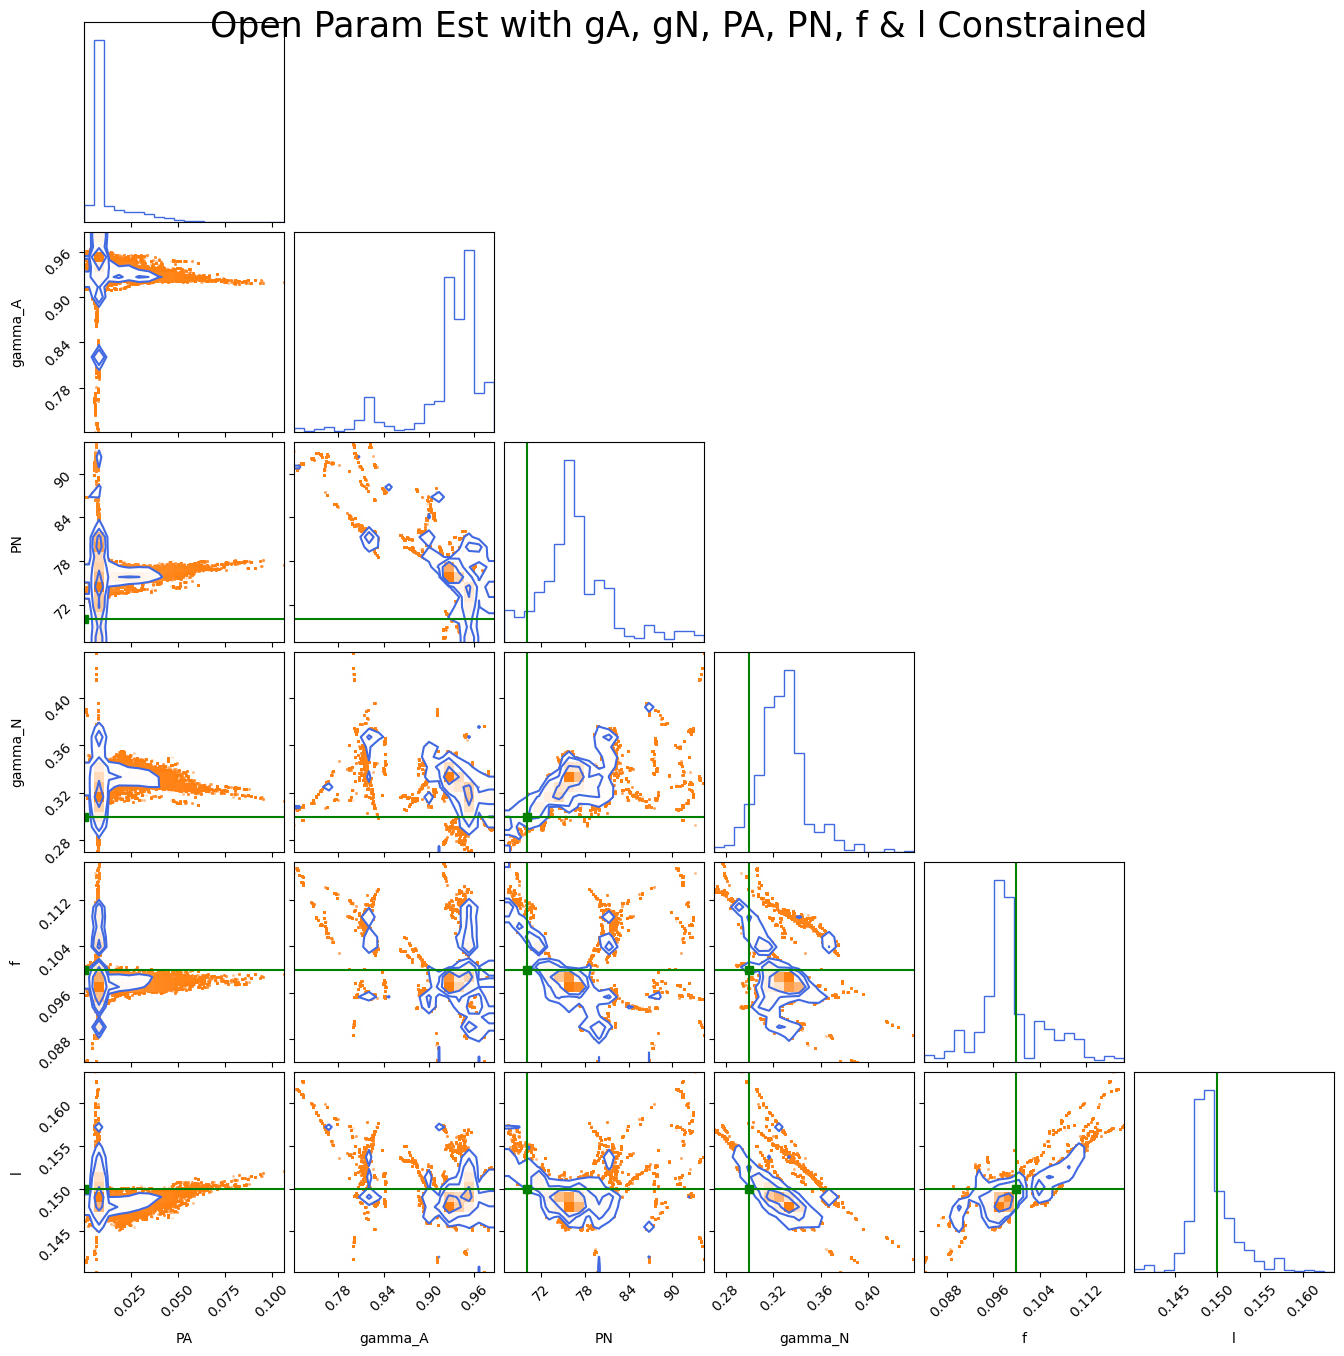

Best-fit parameters (Maximum Likelihood Estimate): [0.05614414222743277, 0.9256001952306829, 77.46898726763676, 0.32599248956509475, 0.09751569271576004, 0.1496712631056037]


In [10]:
parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples_o, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Open Param Est with gA, gN, PA, PN, f & l Constrained", fontsize=25)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/Open_All_15cm_1.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_o)

In [ ]:
#creating a CSV for storing the best fit parameters
data=[["PA", "gamma_A", "PN", "gamma_N", "f","l"],
      [round(i, 2) for i in ip_params],
      [round(p, 2) for p in best_fit_params_o]]
priors=["Priors: gA, gN, PA, PN, f, L  & seed: "+str(seed)]

with open('Estimated_params_open.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(priors)
    writer.writerows(data)
    
print(seed)  

Text(0.5, 1.0, 'TA obs vs exp')

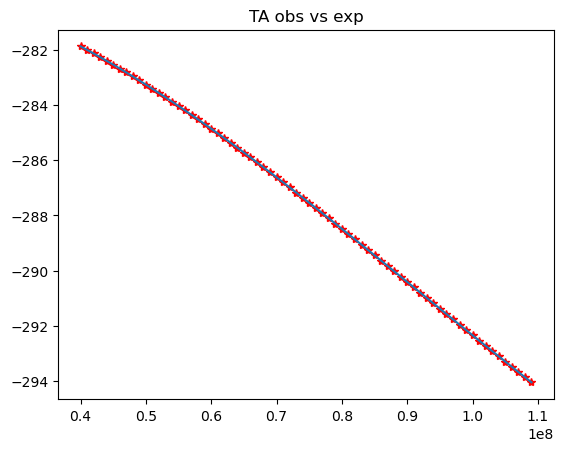

In [11]:
#Reconstructing TA 
TA_exp_o=Compute_Tmeas_(0,1,70,0.3,0.1,0.15)
op_params=best_fit_params_o
TA_mod_o=Compute_Tmeas_(*op_params)
plt.plot(freq,TA_exp_o,"*r")
plt.plot(freq,TA_mod_o)
plt.title("TA obs vs exp")

## MCMC for RLC coeffs with fixed params from open

In [8]:
########## Define the log-likelihood function
def log_likelihood(params,**kwargs):

    ip_params = kwargs["ip_params"]
    PN = kwargs["PN"]
    gamma_N = kwargs["gamma_N"]
    f = kwargs["f"]
    l = kwargs["l"]
    s = kwargs["s"]
    seed=kwargs["seed"]

    # Compute TA expected
    
    PA, p0, p1, p2, p3, p4, p5, p6 = ip_params
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN,gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    PA, p0, p1, p2, p3, p4, p5, p6 = params
    TA_model = Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params,**kwargs):

    PA, p0, p1, p2, p3, p4, p5, p6 = params
    v=kwargs["v"]
    
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1 and (250<PA<350)):
        return 0.0  # Uniform prior
    return -np.inf #reject
    
######### Define the full log-probability function
    
def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_RLC(**kwargs):
        
    ## Number of walkers and steps
    
    ndim = 8  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value = kwargs["initial_value"] 

    ## Starting positions for the walkers
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood(p,**kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [9]:
PA=300
s=0.001
seed=69
v=[d[i][0] for i in range(len(d)-1)]
nsteps=3000
PA_o, gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
ip_params=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]
initials=[301, -6,  2.4, -4.1,  4.0, -1.96,  4.7,  4.5]

kwargs={"nsteps":nsteps,"initial_value":initials,"ip_params": ip_params, "PN":PN,  "gamma_N":gamma_N, "f":f, "l":l, "s":s, "v":v, "seed":seed}

full_samples_rlc, samples_rlc, best_fit_params_rlc= evolve_MCMC_RLC(**kwargs)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [20:33<00:00,  2.43it/s]


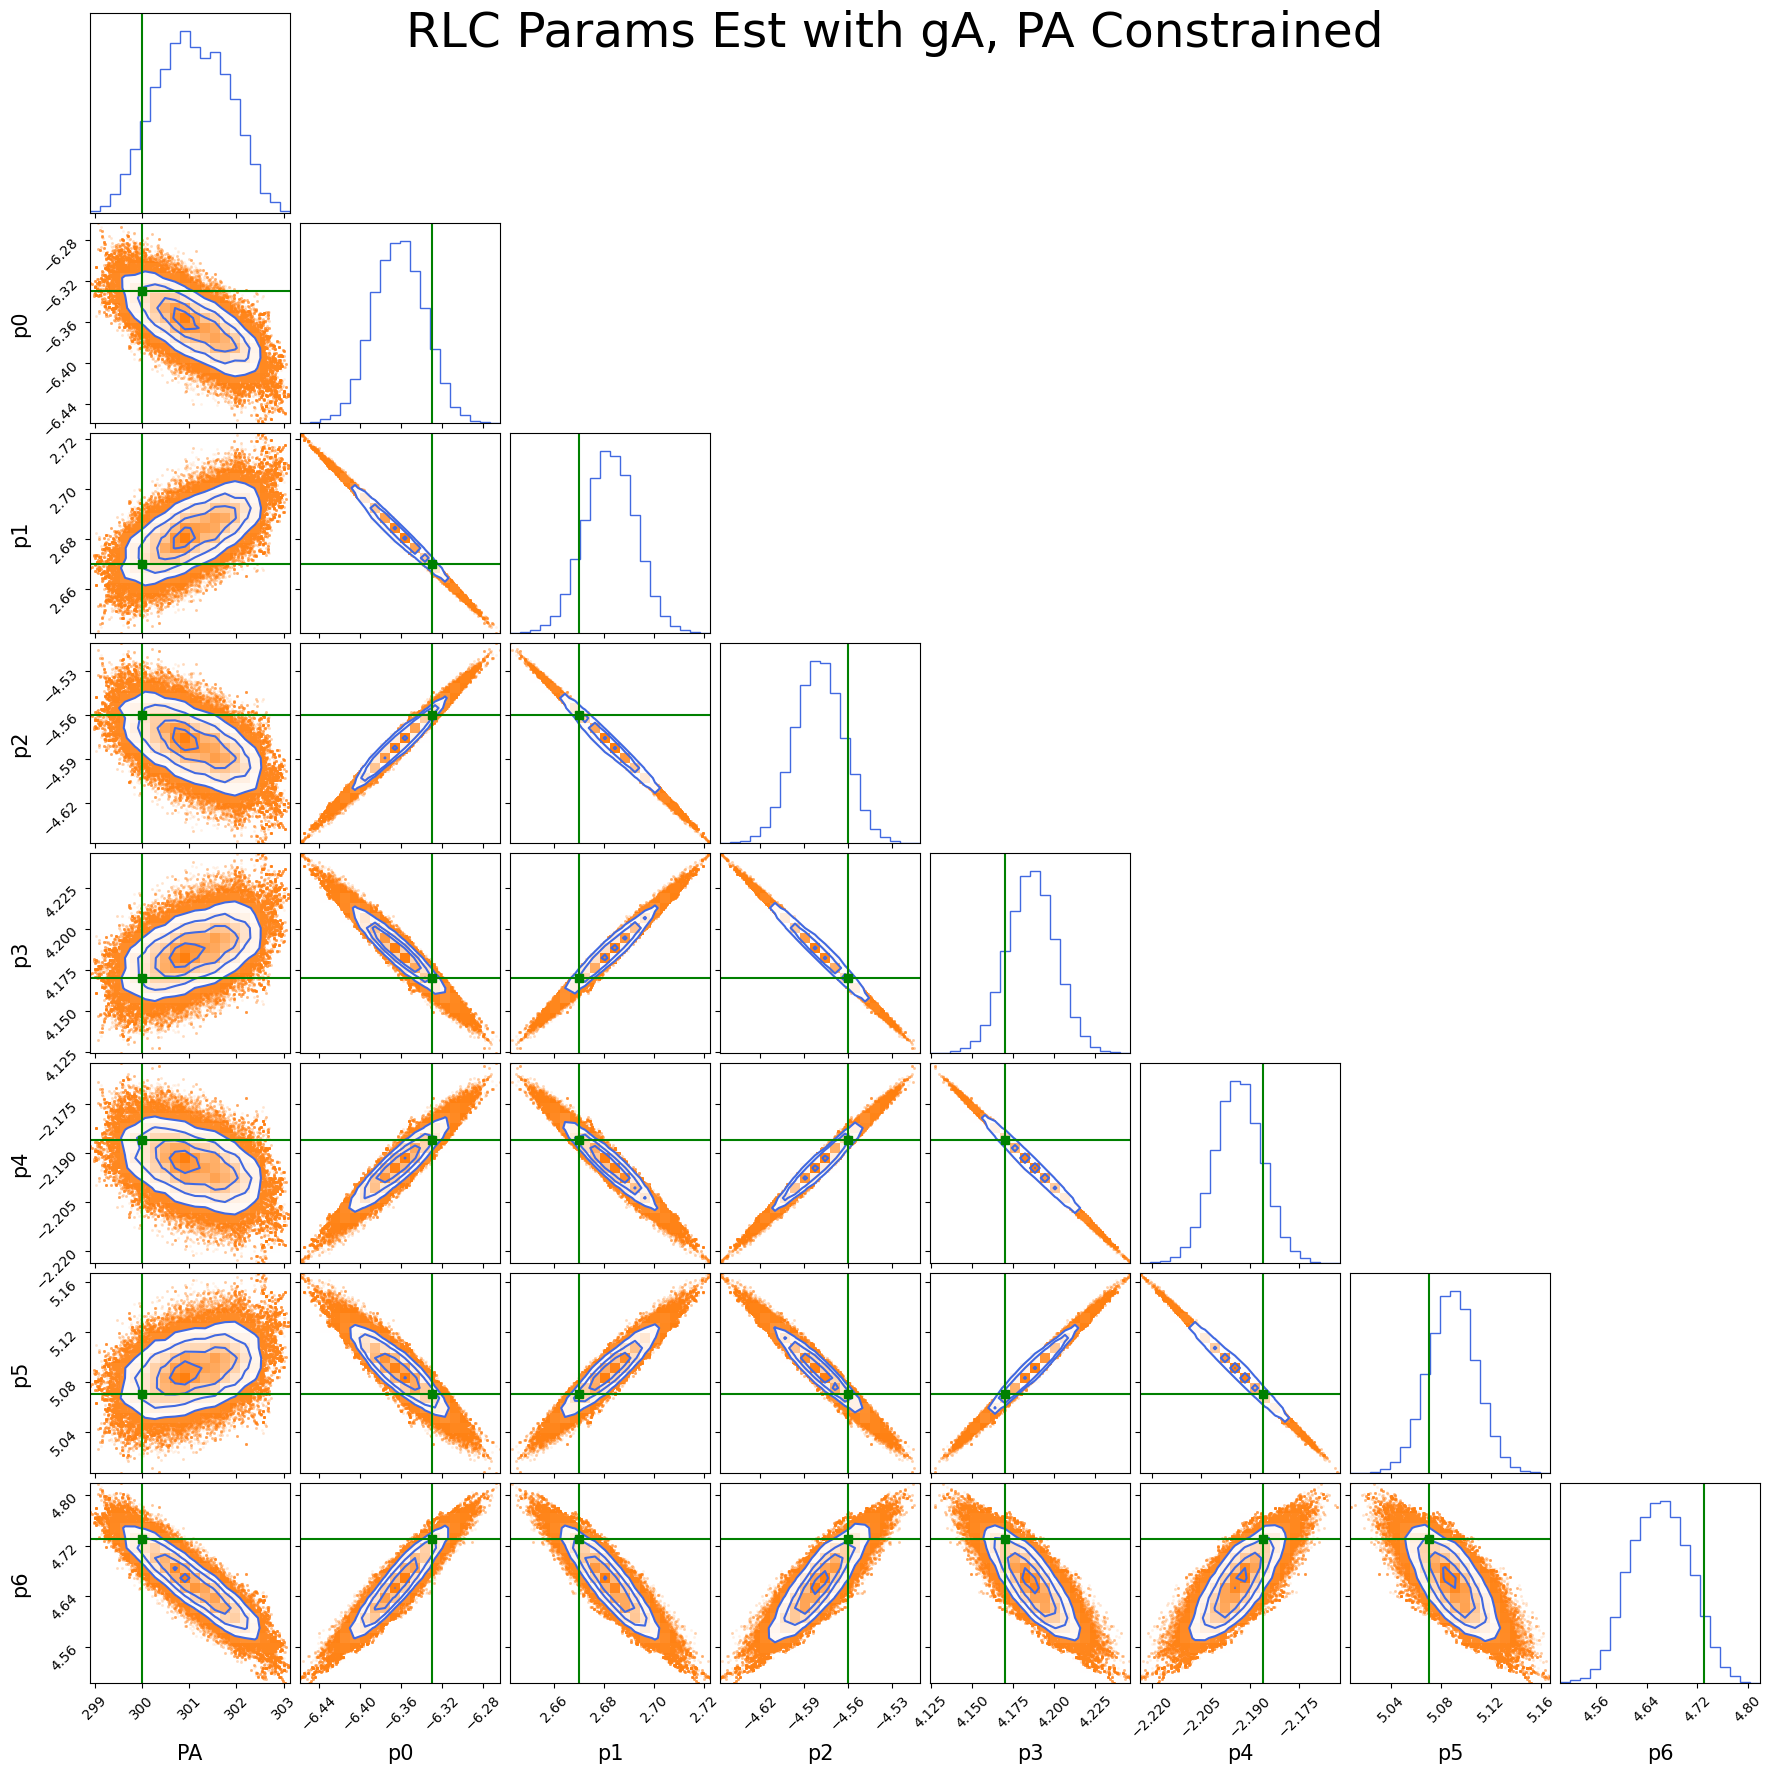

Best-fit parameters (Maximum Likelihood Estimate): [300.2186508010602, -6.34372416967788, 2.6756828269677, -4.5697270043607325, 4.178742995447257, -2.19043926824778, 5.0817269150262945, 4.707043691110647]


In [10]:
parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6"]
#corner plot 
fig = corner.corner(samples_rlc, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("RLC Params Est with gA, PA Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_gA_PA_2m_1.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_rlc)

In [11]:
#computing S11 corresponding to all samples
reduced_samples_rlc = samples_rlc
S11_models_rlc = np.zeros((len(reduced_samples_rlc), len(v)))

for ii in range(len(reduced_samples_rlc)):
    PA, p0, p1, p2, p3, p4, p5, p6= reduced_samples_rlc[ii]
    S11_models_rlc[ii]=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

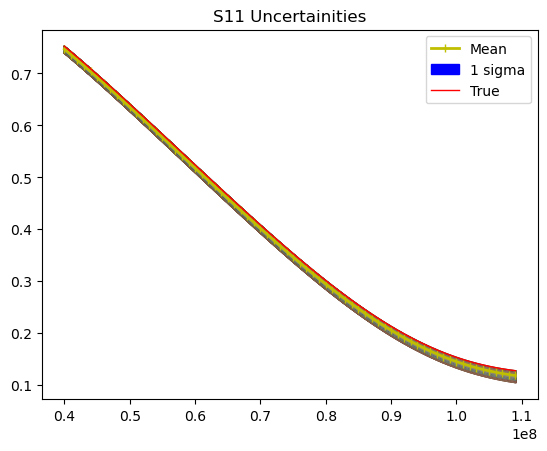

In [12]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
plt.plot(v, S11_models_rlc[0::100].T, alpha=0.1)

S11_mean_rlc = np.mean(S11_models_rlc, axis=0)
lower_bound, upper_bound = np.percentile(S11_models_rlc,[16,84],axis=0)

plt.plot(v, S11_mean_rlc, lw=2, color='y', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='b', zorder=-1, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]

gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gA_True, color='r', lw=1.0, label="True")
plt.title("S11 Uncertainities")
plt.legend()
plt.show()

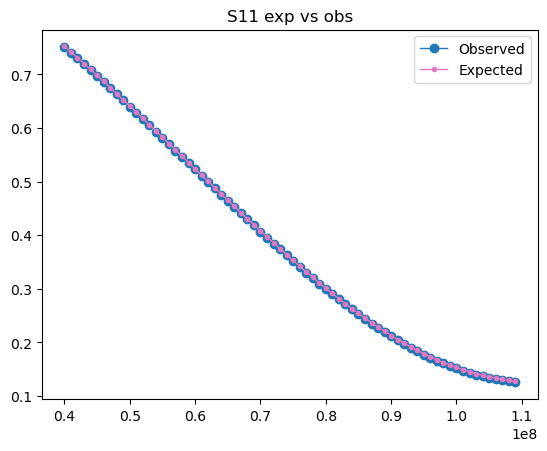

In [14]:
Pa,p0, p1, p2, p3, p4, p5, p6=best_fit_params_rlc

gA_obs=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gA_obs, color='tab:blue', lw=1.0, marker='o',label="Observed")

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]
gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gA_True, color='tab:pink', lw=1.0, marker='.', label="Expected")
plt.title("S11 exp vs obs")
plt.legend()

Text(0.5, 1.0, 'Uncertainities Exp vs Obs TA')

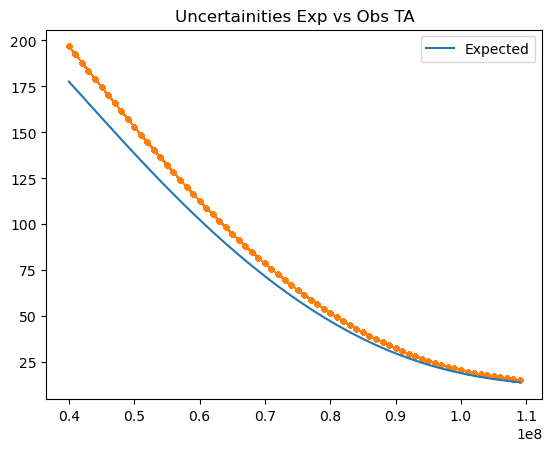

In [17]:
#Recovering Uncertainities in Tmeas
for ii in range(len(reduced_samples_rlc[::100])):
    PA, p0, p1, p2, p3, p4, p5, p6= reduced_samples_rlc[ii]
    PA_o, gamma_Ao, PN, gamma_N, f, l=best_fit_params_o#[0,1,70, 0.3, 0.1, 0.15]
    TA_obs=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    plt.plot(v, TA_obs,color='C1', marker=".", alpha=0.1, lw=1)
PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
TA_exp=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
plt.plot(v,TA_exp, label="Expected")
plt.legend()
plt.title("Uncertainities Exp vs Obs TA")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Residuals Exp vs Obs TA')

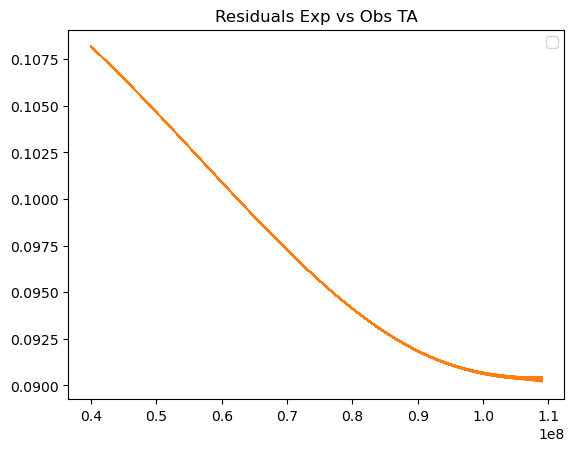

In [18]:
#Recovering residulas in Tmeas
plt.figure()
PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
TA_exp=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)

for ii in range(len(reduced_samples_rlc[::100])):
    PA, p0, p1, p2, p3, p4, p5, p6= reduced_samples_rlc[ii]
    PA_o, gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
    TA_obs=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    res=(np.array(TA_obs)-np.array(TA_exp))/np.array(TA_exp)
    plt.plot(v, res, color='C1',alpha=0.1, lw=1)

#plt.plot(v,TA_exp, label="Expected")
plt.legend()
plt.title("Residuals Exp vs Obs TA")

In [19]:
#creating a CSV for storing the best fit parameters
data=[['PArlc','p0','p1','p2','p3','p4','p5','p6'],
      [round(i, 2) for i in ip_params],
      [round(p, 2) for p in best_fit_params_rlc]]
priors=["Priors: gA,PA & seed: "+str(seed)]

with open('Estimated_params_rlc.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(priors)
    writer.writerows(data)
    
print(seed) 

69


In [ ]:
#Reconstruction 
print(best_fit_params_rlc)
PA, p0, p1, p2, p3, p4, p5, p6=best_fit_params_rlc
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
yerr=abs(rlc-gamma_A)

plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A,label='observed')
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_S11_gA_PA.png', dpi=300)

In [ ]:
#Reconstructing TA 
PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
TA_exp_rlc=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
PAo,gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
PA, p0, p1, p2, p3, p4, p5, p6,=best_fit_params_rlc
TA_mod_rlc=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
plt.plot(freq,TA_exp_rlc,"*r", label="Exp")
plt.plot(freq,TA_mod_rlc,label="Obs")
plt.legend()
plt.title("TA Obs vs Exp")

## MCMC for RLC with Open params as initials

In [20]:
########## Define the log-likelihood function
def log_likelihood(params,**kwargs):

    ip_params = kwargs["ip_params"]
    s = kwargs["s"]
    seed=kwargs["seed"]
    v=kwargs["v"]

    # Compute TA expected
    
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_RLC(PA,p0, p1, p2, p3, p4, p5, p6, PN,gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    TA_model = Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params,**kwargs):
    
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params

    v=kwargs["v"]
    
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1 and (0<=gamma_N<=1) and (250<PA<350) and (50<PN<150) and (0.05<f<0.5) and l>0):
        return 0.0  # Uniform prior
    return -np.inf #reject
    
######### Define the full log-probability function
    
def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_RLC_1(**kwargs):
    
    ## Number of walkers and steps
    
    ndim = 12  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=kwargs["initial_value"]

    ## Starting positions for the walkers
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    
    
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler_rlc_1 = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    mean_acc_frac=np.mean(sampler_rlc_1.acceptance_fraction)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler_rlc_1.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples_rlc_1=sampler_rlc_1.get_chain()
    samples_rlc_1 = sampler_rlc_1.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes_rlc_1 = np.array([log_likelihood(p,**kwargs) for p in samples_rlc_1])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes_rlc_1)
    
    ## Get the best-fit parameters
    
    best_fit_params_rlc_1 = samples_rlc_1[max_likelihood_index].tolist()

    return full_samples_rlc_1,samples_rlc_1,best_fit_params_rlc_1, mean_acc_frac #Mean Acceptance Ratio

In [21]:
PA=300
s=0.001
seed=154
nsteps=3000
v=[d[i][0] for i in range(len(d)-1)]
ip_params=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
PAo,gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
PA, p0, p1, p2, p3, p4, p5, p6=[301, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73,]#best_fit_params_rlc
initials=[PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l]


kwargs={"nsteps": nsteps, "ip_params": ip_params, "initial_value": initials, "s":s, "v":v, "seed":seed} #"PN":PN,  "gamma_N":gamma_N, "f":f, "l":l,


full_samples_rlc_1, samples_rlc_1, best_fit_params_rlc_1, mean_acc_frac= evolve_MCMC_RLC_1(**kwargs)


Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [19:34<00:00,  2.55it/s]


In [ ]:
print("Acceptance fraction:", sampler_rlc_1.acceptance_fraction)

In [22]:
nsamples, nparam = samples_rlc_1.shape

In [23]:
reduced_samples_1 = samples_rlc_1

In [24]:
#computing S11 corresponding to all samples
S11_models = np.zeros((len(reduced_samples_1), len(v)))
NP=np.zeros(len(reduced_samples_1))
for ii in range(len(reduced_samples_1)):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_1[ii]
    S11_models[ii]=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    NP[ii]=gamma_N


In [ ]:
#selecting only the indices where the S11 is less than 1 wrt frequency
ind_select = (np.amax(S11_models, axis=1)<=1)
prior_samples_1 = S11_models[ind_select]

In [ ]:

plt.plot(np.arange(len(reduced_samples_1)),NP,'.r')


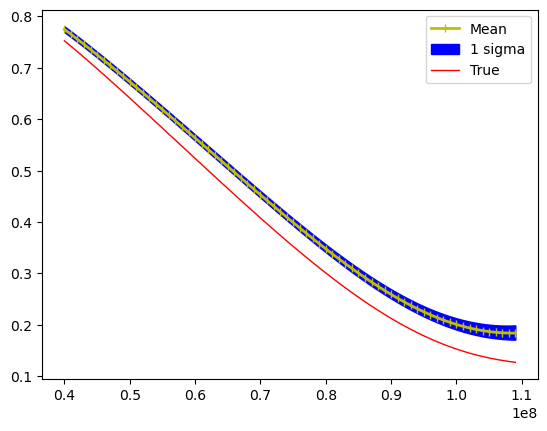

In [26]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
#plt.plot(v, S11_models[0::100].T, alpha=0.1)

S11_mean = np.mean(S11_models, axis=0)
lower_bound, upper_bound = np.percentile(S11_models,[16,84],axis=0)

plt.plot(v, S11_mean, lw=2, color='y', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='b', zorder=-1, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]

gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gA_True, color='r', lw=1.0, label="True")
plt.legend()
plt.show()

Text(0.5, 1.0, 'S11 exp vs obs')

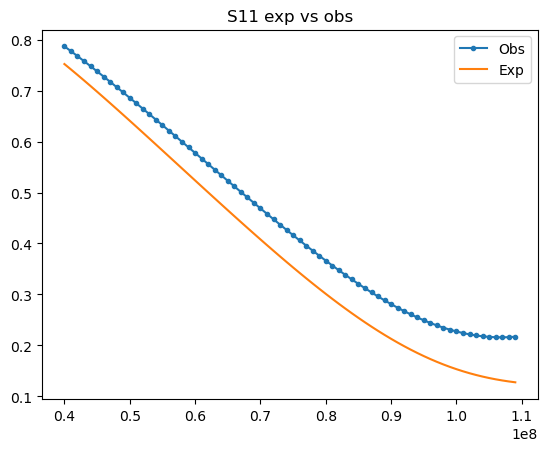

In [27]:
plt.figure()
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=best_fit_params_rlc_1
TA_obs=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
S11_obs=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

TA_exp=Compute_Tmeas_RLC(300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15)
p0, p1, p2, p3, p4, p5, p6= -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73
S11_actual=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

plt.plot(v, S11_obs, marker=".", label="Obs")
plt.plot(v, S11_actual, label="Exp")
plt.legend()
plt.title("S11 exp vs obs")


Text(0.5, 1.0, 'Tmeas Expected vs Observed')

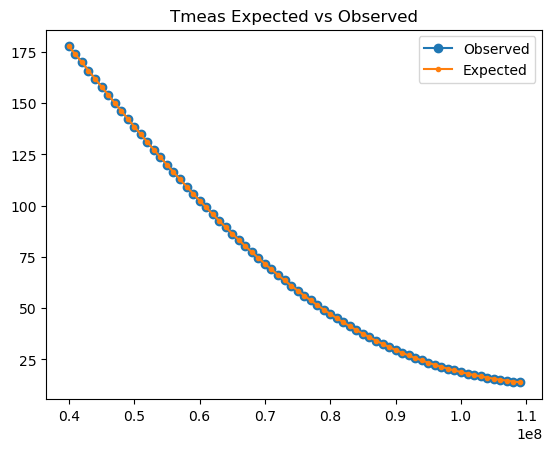

In [28]:
plt.plot(v,TA_obs,marker='o', label="Observed")
plt.plot(v,TA_exp, marker='.', label="Expected")
plt.legend()
plt.title("Tmeas Expected vs Observed")

Text(0.5, 1.0, 'Uncertainities in Recovering Tmeas')

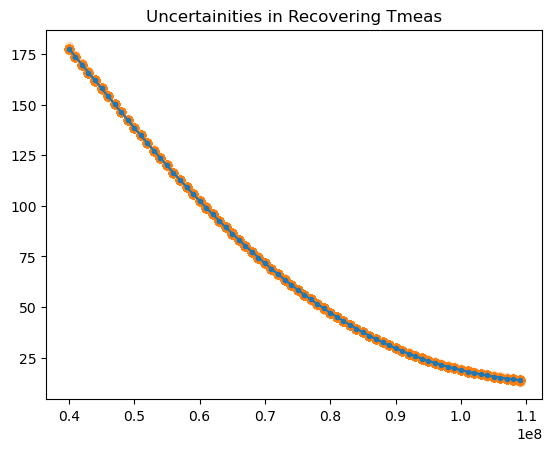

In [30]:
#Uncertainities in Recovering Tmeas
PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
TA_exp=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
for ii in range(len(reduced_samples_1[::1000])):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_1[ii]
    TA_obs=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    #plt.plot(v, TA_obs,color='C1',alpha=0.1, lw=1)
    err=(np.array(TA_obs)-np.array(TA_exp))
    plt.plot(v, TA_obs, color='C1',alpha=0.1,marker='o', lw=1)

plt.plot(v,TA_exp, marker='.')
#plt.ylim(-0.025,0.025)
plt.title("Uncertainities in Recovering Tmeas")

484


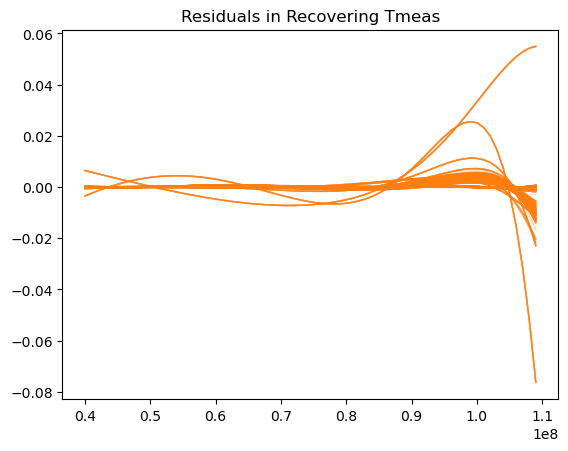

In [33]:
#Residuals in Recovering Tmeas
plt.figure()
count=0
PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
TA_exp=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
for ii in range(len(reduced_samples_1[::100])):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_1[ii]
    TA_obs=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    #plt.plot(v, TA_obs,color='C1',alpha=0.1, lw=1)
    err=(np.array(TA_obs)-np.array(TA_exp))/np.array(TA_exp)
    if (np.amin(err)<-0.01 or np.amax(err)>0.01):
        count=count+1
    plt.plot(v, err, color='C1',alpha=0.1, lw=1)


plt.title("Residuals in Recovering Tmeas")
print(count)

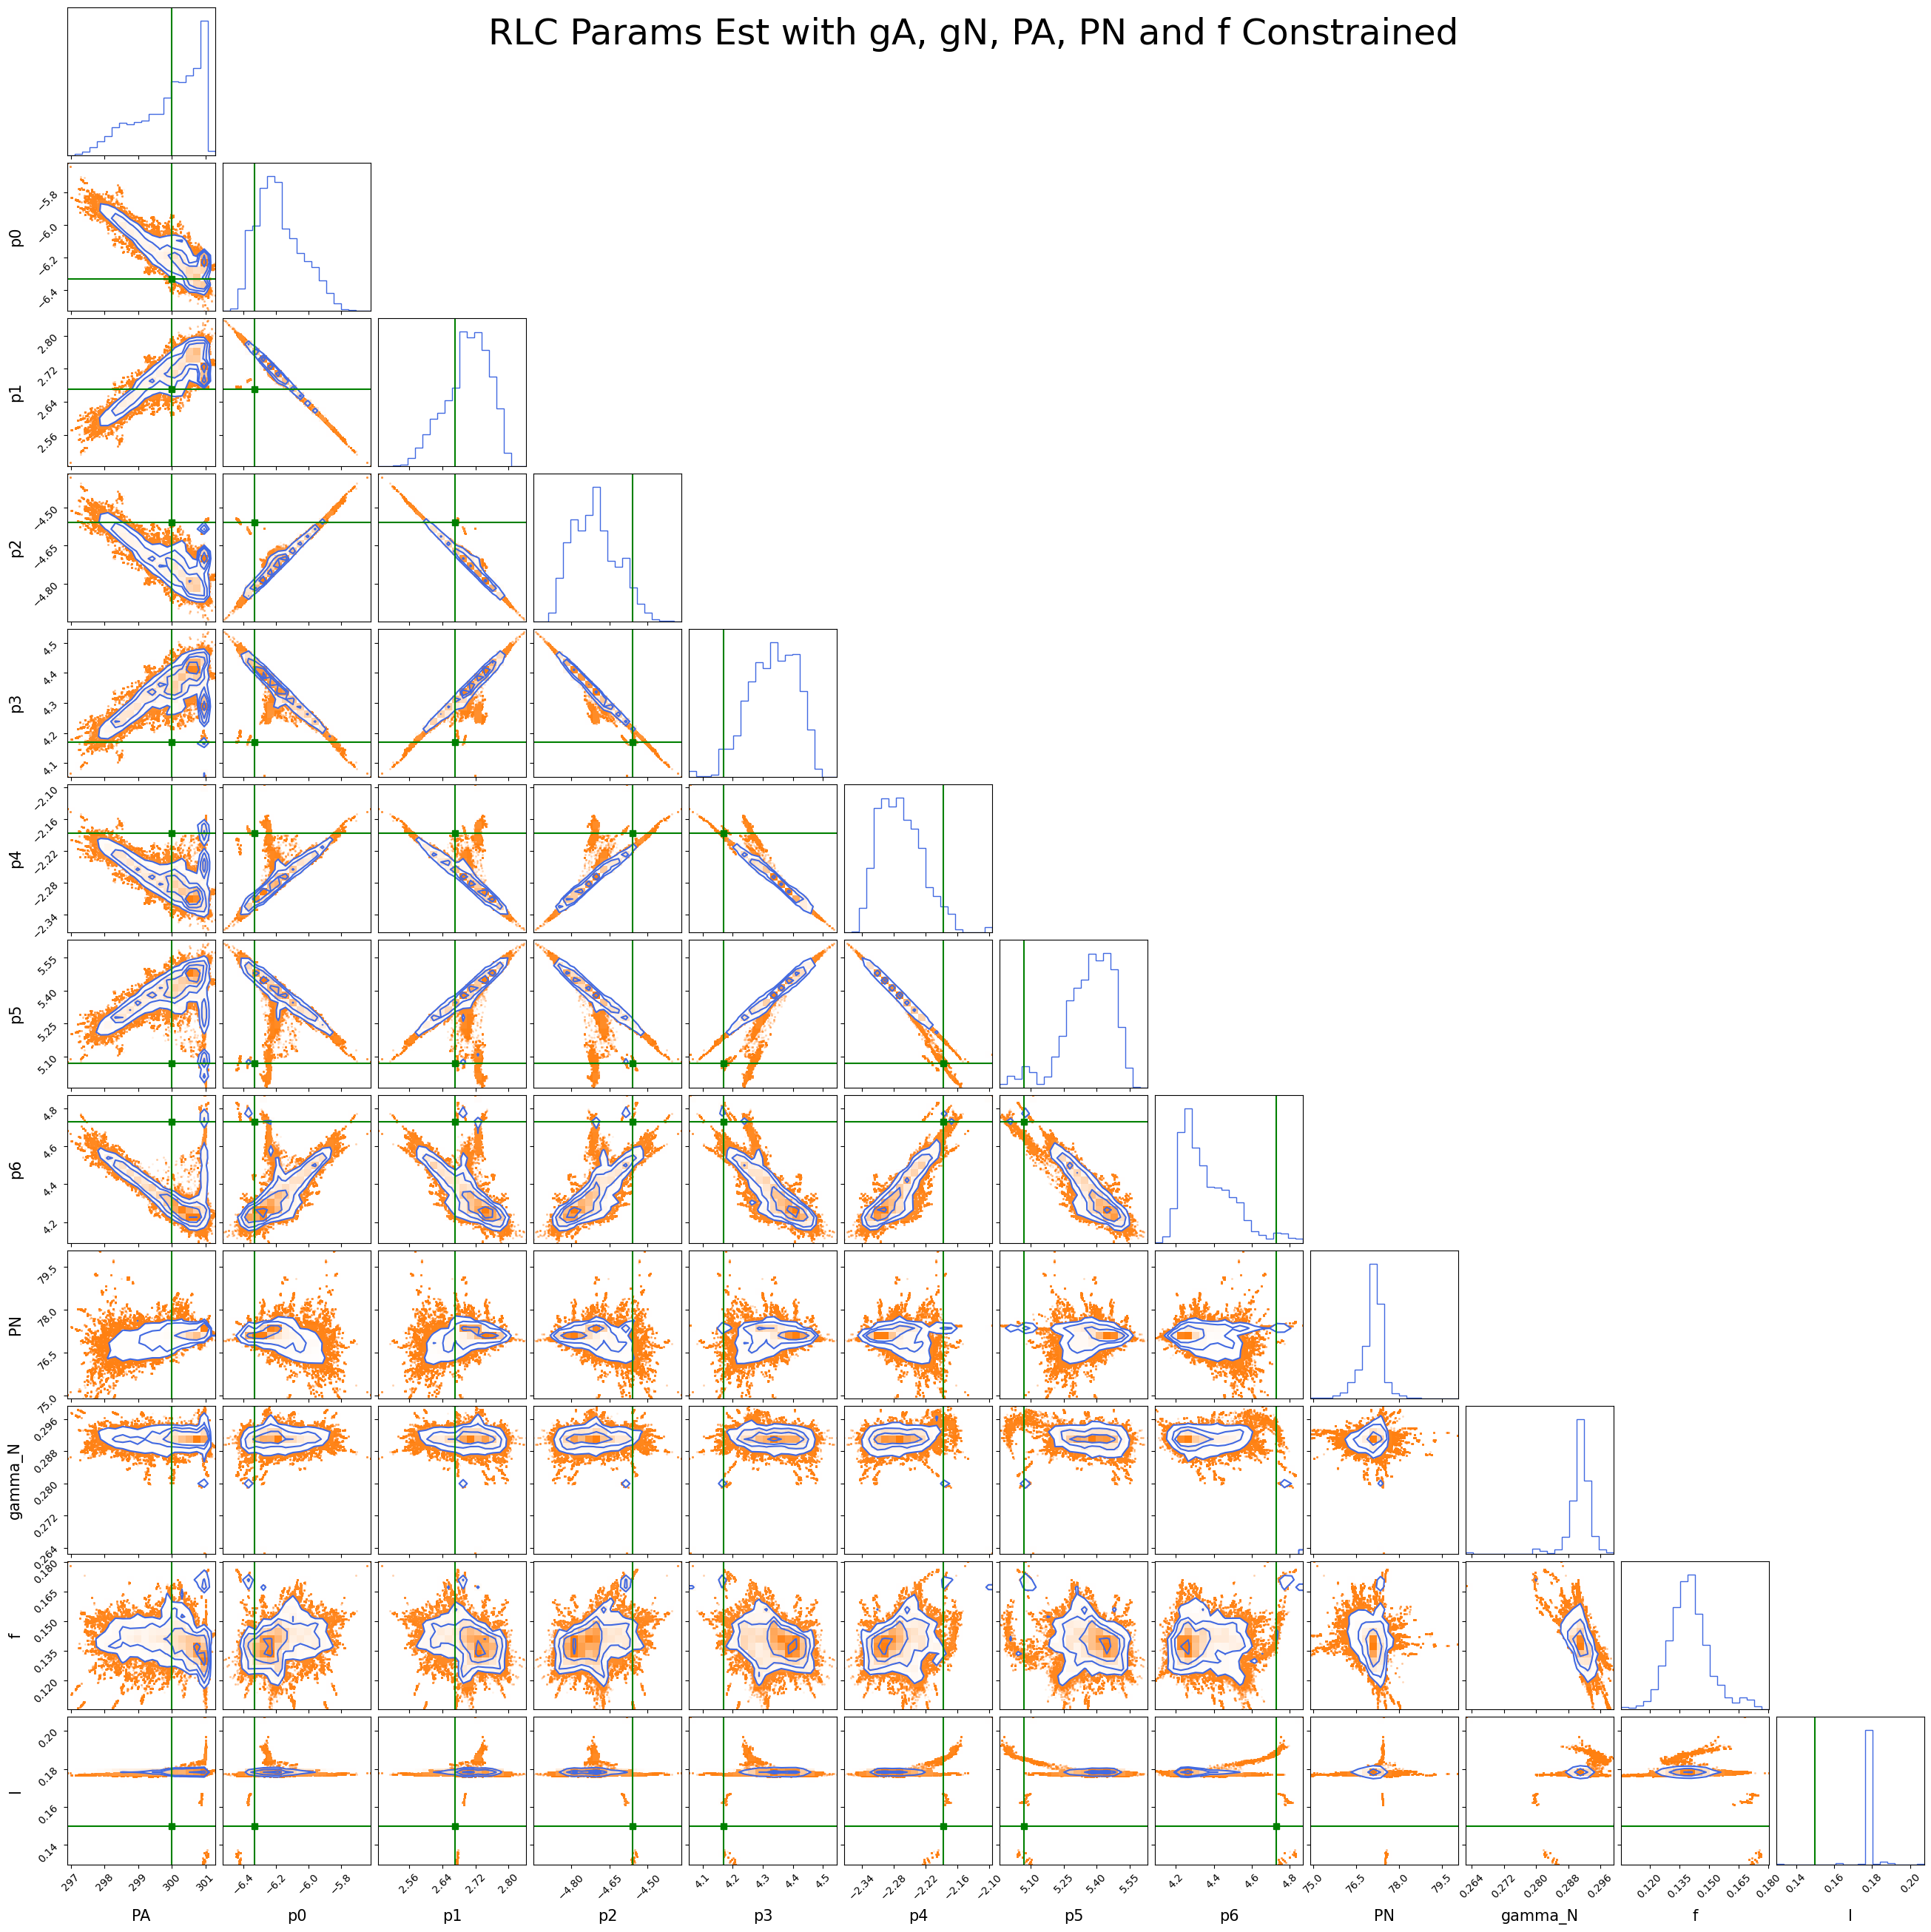

True values: [300, -6.33, 2.67, -4.56, 4.17, -2.186, 5.07, 4.73, 70, 0.3, 0.1, 0.15]
Best-fit parameters (Maximum Likelihood Estimate): [297.3639582514301, -5.780598918714411, 2.5464770562546994, -4.464632593308799, 4.132225422383803, -2.174941950087251, 5.146808416690021, 4.695455357719297, 76.15532882835147, 0.28831955905216067, 0.15426961003687384, 0.17711392463278305]


In [34]:
parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6","PN","gamma_N","f","l"]
#corner plot 
fig = corner.corner(samples_rlc_1, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("RLC Params Est with gA, gN, PA, PN and f Constrained", fontsize=35)
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/RLC_1m_gA_gN_PA_l_1.png', dpi=300)
plt.show()

print("True values:", ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_rlc_1)

In [ ]:
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=best_fit_params_rlc_1
TA_exp=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
mean_TA = np.mean(TA_exp)
std_dev_TA = np.std(TA_exp)
lower_bound_TA = mean_TA - std_dev_TA
upper_bound_TA = mean_TA + std_dev_TA

In [ ]:
#Uncertainity in TA 
#TA_exp=TA_exp = Compute_Tmeas_RLC_exp(300,70,0.3,0.1,0.15)
total=0
inbound=0
outbound=0
for i in range(12):
    for j in range(1000):
        #len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
        #print(i,j)
        PA,po,p1,p2,p3,p4,p5,p6,PN,gN,f,l=one_sigma_samples_rlc_1[:][i][j]
        #total+=1
        gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
        if lower_bound<=np.mean(gamma_A)<=upper_bound:#if np.amax(gamma_A)<=1:
            total+=1
            TA_obs=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
            if lower_bound_TA<=np.mean(TA_obs)<=upper_bound_TA:
                inbound+=1
                plt.plot(v, TA_obs,color='C1',alpha=0.1, lw=1)
            else:
                outbound+=1
            #coeffs.append(one_sigma_samples_rlc_1[i][j])
plt.plot(v,TA_exp,'b', label='Actual TA')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('TA')
plt.title("TA Exp vs Obs")
plt.legend()

In [ ]:
print(total,inbound,outbound)

In [ ]:
#Reconstruction 
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=best_fit_params_rlc_1
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
yerr=abs(rlc-gamma_A)

plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A,label='observed')
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/RLC_2m_S11_none.png', dpi=300)

In [ ]:
#Reconstructing TA 
TA_exp_rlc=Compute_Tmeas_RLC_exp(300,70,0.3,0.1,1)
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =best_fit_params_rlc_1
TA_mod_rlc=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
plt.plot(freq,TA_exp_rlc,"*r", label="Exp")
plt.plot(freq,TA_mod_rlc, label="Obs")
plt.title("TA Exp vs Obs")
plt.legend()

In [ ]:
#Uncertainity in TA 
TA_exp=Compute_Tmeas_RLC_exp(300,70,0.3,0.1,2)
for i in range(7):
    for j in range(1000):
        #len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
        #print(i,j)
        PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =one_sigma_samples[:][i][j]
        TA_obs=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
        plt.plot(v, TA_obs,color='C1',alpha=0.1, lw=1)
plt.plot(v,TA_exp,'r', label='Actual TA')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('TA')
plt.title("TA Exp vs Obs")
plt.legend()

## Joint Open +Load with Open values as initials

In [ ]:
########## Define the log-likelihood function
def log_likelihood_ol(params, **kwargs):
    
    ip_params=kwargs["ip_params"]
    PAo, gamma_Ao, PAl, gamma_Al, PN, gamma_N, f, l = ip_params
    
    seed=kwargs["seed"]
    np.random.seed(seed)
    
    # Define the Expected TA values for open
    TA_exp_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_o=np.array(TA_exp_o)
    
    # Define the Expected TA values for Load
    TA_exp_l = Compute_Tmeas_(PAl, gamma_Al, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_l=np.array(TA_exp_l)


    PAo, gamma_Ao, PAl, gamma_Al, PN, gamma_N, f, l = params
    
    # Compute model TA for open
    TA_model_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l)
    TA_model_o=np.array(TA_model_o)

    # Compute model TA for load
    TA_model_l = Compute_Tmeas_(PAl, gamma_Al, PN, gamma_N, f, l)
    TA_model_l=np.array(TA_model_l)
    
    
    s = kwargs["s"] # Uncertainty
    
    # Compute chi-squared for Open
    
    chi2_o = np.sum([((TA_exp_o - TA_model_o)/s)** 2 ]) 
    
    # Compute chi-squared for Load
    
    chi2_l = np.sum([((TA_exp_l - TA_model_l)/s)** 2 ]) 

    # Likelihood function
    Likelihood= -0.5*chi2_o - 0.5*chi2_l - 2*np.log(math.sqrt(2*np.pi)*s) 
    return Likelihood

########## Define the log-prior function
def log_prior_ol(params,**kwargs):
    
    PAo, gamma_Ao, PAl, gamma_Al, PN, gamma_N, f, l = params
    v=kwargs["v"]
    #gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    if ((0<=gamma_Ao<=1) and (0<=gamma_Al<=1) and (0<=gamma_N<=1) and (0.05<l<5)):
        return 0.0  # Uniform prior
    return -np.inf #reject
          

######### Define the full log-probability function

def log_probability_ol(params,**kwargs):
    lp = log_prior_ol(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_ol(params,**kwargs)

########### MCMC

def evolve_MCMC_OL(**kwargs):# Define parameter names
 
    # Number of walkers and steps
    ndim = 8 # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(kwargs["initial_value"])
    
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    ## Starting positions for the walkers
    pos= initial_value[None,:] + initial_value*1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 

    def wrap_log_probability_ol(params):
        return log_probability_ol(params, **kwargs)
        
    ############ Set up the MCMC sampler
    sampler_ol = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability_ol, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler_ol.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples_ol=sampler_ol.get_chain()
    samples_ol = sampler_ol.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes_ol = np.array([log_likelihood_ol(p,**kwargs) for p in samples_ol])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes_ol)
    
    ########## Get the best-fit parameters
    best_fit_params_ol = samples_ol[max_likelihood_index].tolist()

    return full_samples_ol,samples_ol,best_fit_params_ol

In [ ]:
# Evaluate MCMC
s=0.001
nsteps=3000
v=[d[i][0] for i in range(len(d)-1)]
PAo,gamma_Ao, PN, gamma_N, f, l= best_fit_params_o
PAl, gamma_Al=[300.3, 0.02]
seed=17
ip_params=[0, 1, 300, 0, 70, 0.3, 0.1, 2]
initials=[PAo, gamma_Ao, PAl, gamma_Al, PN, gamma_N, f, l ]

kwargs={"nsteps":nsteps, "ip_params":ip_params,"initial_value": initials, "s":s, "v":v, "seed":seed}

full_samples_OL, samples_OL, best_fit_params_OL= evolve_MCMC_OL(**kwargs)

In [ ]:
parameter_names = ["PAo", "gamma_Ao" ,"PAl", "gamma_AL","PN","gamma_N","f","l"]
#corner plot 
fig = corner.corner(samples_OL, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Load and Open Params Est with gA, gN, l Constrained", fontsize=35)
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/Load_Open_2m_gA_gN_l_1.png', dpi=300)
plt.show()

print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_OL)

## Joint RLC+Open with Open as initials

In [35]:
########## Define the log-likelihood function
def log_likelihood(params, **kwargs):
    
    ip_params=kwargs["ip_params"]
    seed=kwargs["seed"]
    v=kwargs["v"]
    
    PAo, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
    
    
    np.random.seed(seed)
    
    # Define the Expected TA values for open
    TA_exp_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_o=np.array(TA_exp_o)

    # Define the Expected TA values for RLC
    TA_exp_rlc = Compute_Tmeas_RLC(PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_rlc=np.array(TA_exp_rlc)

    PAo, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    
    # Compute model TA for open
    TA_model_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l)
    TA_model_o=np.array(TA_model_o)

    # Compute model TA for open
    TA_model_rlc = Compute_Tmeas_RLC(PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    TA_model_rlc=np.array(TA_model_rlc)
    
    # Compute chi-squared for open
    s = kwargs["s"] # Uncertainty
    chi2_o = np.sum([((TA_exp_o - TA_model_o)/s)** 2 ]) 

    # Compute chi-squared for RLC
    s = kwargs["s"]  # Uncertainty
    chi2_rlc = np.sum([((TA_exp_rlc - TA_model_rlc)/s)** 2 ]) 

    # Likelihood function
    Likelihood= -0.5*chi2_o-0.5*chi2_rlc #-2*np.log(math.sqrt(2*np.pi)*s) 
    return Likelihood

########## Define the log-prior function
def log_prior(params,**kwargs):
    
    PAo, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    v=kwargs["v"]
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

    if (min(gamma_A>=0) and max(gamma_A)<=1 and (0<=gamma_Ao<=1) and (0<=gamma_N<=1) and (0.05<l<5)and PAo>0 and PN>0 and f>0):
        return 0.0  # Uniform prior
    return -np.inf #reject
          

######### Define the full log-probability function

def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)

########### MCMC

def evolve_MCMC_Joint(**kwargs):# Define parameter names
 
    # Number of walkers and steps
    ndim = 14  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(kwargs["initial_value"])
    
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    ## Starting positions for the walkers
    pos= initial_value[None,:] + initial_value*1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 

    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
        
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(p,**kwargs) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [36]:
#PA=300
s=0.001
nsteps=3000
v=[d[i][0] for i in range(len(d)-1)]
PA_o,gamma_Ao,PN,gamma_N,f,l=best_fit_params_o
PArlc, p0, p1, p2, p3, p4, p5, p6,PN, gamma_N, f,l= best_fit_params_rlc_1
seed=386
ip_params=[0, 1, 300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
initials=[PA_o, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l ]

kwargs={"nsteps":nsteps, "ip_params":ip_params,"initial_value": initials, "s":s, "v":v, "seed":seed}

full_samples_joint, samples_joint, best_fit_params_joint= evolve_MCMC_Joint(**kwargs)

Running MCMC...


  0%|                                                  | 0/3000 [00:00<?, ?it/s]/home/saurabhs/anaconda3/envs/saras/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 3000/3000 [17:28<00:00,  2.86it/s]


In [ ]:
parameter_names = ["PAo", "gamma_A", "PARLC", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples_joint, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Joint Para Est with gA, gAo, gN, L Constrained", fontsize=35)
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Joint_ORLC_1m_gA_gAo_gN_L_1.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_joint)

In [ ]:
#computing S11 corresponding to all samples
reduced_samples_joint = samples_joint
S11_models_joint = np.zeros((len(reduced_samples_joint), len(v)))

for ii in range(len(reduced_samples_joint)):
    PA_o, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_joint[ii]
    S11_models_joint[ii]=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

In [ ]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
#plt.plot(v, S11_models_joint[0::100].T, alpha=0.1)

S11_mean_joint = np.mean(S11_models_joint, axis=0)
lower_bound, upper_bound = np.percentile(S11_models_joint,[16,84],axis=0)

plt.plot(v, S11_mean_joint, lw=2, color='k', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='y', zorder=-1, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]

gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gA_True, color='r', lw=1.0, label="True")
plt.legend()
plt.title("S11 Uncertainities")
plt.show()

In [ ]:
PA_o, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=best_fit_params_joint

gA_obs=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gA_obs, color='tab:blue', lw=1.0,label="Observed")

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]
gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

yerr=abs(gA_obs-gA_True)
#plt.errorbar(v, gA_obs, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gA_True, color='tab:pink', lw=1.0, label="Expected")
#plt.plot(v,rlc, color='r', lw=1.0, label="Actual")
plt.legend()
plt.title("S11 exp vs obs")

In [ ]:
#Recovering Uncertainities in TA
PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
TA_exp=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
for ii in range(len(reduced_samples_joint[::100])):
    PA_o, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_joint[ii]

    Ta=Compute_Tmeas_RLC(PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    res=(np.array(TA_exp)-np.array(TA_obs))/np.array(TA_exp)
    #plt.plot(v,res,color='g',alpha=0.1, lw=1)
    plt.plot(v,TA_obs,color='g', marker='o',alpha=0.1, lw=1)
    

#PA_o, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=best_fit_params_joint
#TA_best=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
plt.plot(v,TA_exp,'y', marker='.', label="Expected")
#plt.plot(v,TA_best, label="Best")
plt.legend()
plt.title("Exp vs Obs TA")

In [ ]:
#checking other params
y=np.zeros(len(reduced_samples_joint[::10]))
for ii in range(len(reduced_samples_joint[::10])):
    PA_o, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_joint[ii]
    y[ii]=gamma_N
x=np.arange(len(reduced_samples_joint[::10]))
plt.plot(x,y)

In [ ]:
#creating a CSV for storing the best fit parameters
data=[["PAo", "gamma_A", "PARLC", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"],
      [round(i, 2) for i in ip_params],
      [round(p, 2) for p in best_fit_params_joint]]
priors=["Priors: gA, gAo,gN, L & seed: "+str(seed)]
sd=[str(seed)]
with open('Estimated_params_joint.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(priors)
    #writer.writerow(sd)
    writer.writerows(data)
    
print(seed) 

In [ ]:
#Reconstructed S11
v=[d[i][0] for i in range(len(d)-1)]
PA_o, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=best_fit_params_joint

gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
yerr=abs(rlc-gamma_A)
plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A, label='Obeserved')
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Joint_ORLC_S11_gA_gAo_gN_L.png', dpi=300)

In [ ]:
#PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = best_fit_params
PAo, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= best_fit_params_joint
Ta=Compute_Tmeas_RLC(PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
ip_params=[300,-6.33,  2.67, -4.56,  4.2, -2.2,  5.1,  4.7, 70, 0.3, 0.1, 0.15]
print(ip_params)
PAo, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=[0, 1, 300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
TA=Compute_Tmeas_RLC(PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
v=[d[i][0] for i in range(len(d)-1)]
plt.plot(v,Ta,label='Observed', color='C1',alpha=0.3, lw=6)
plt.plot(v,TA,label='Expected', color='brown')
plt.legend()
plt.title('TA vs Freq for Joint RLC+Open')
#plt.savefig('/Users/gopipatel/Desktop/Comparision_plot_2m.png', dpi=300)

In [ ]:
#checking other params
y=np.zeros(len(reduced_samples_joint[::10]))
for ii in range(len(reduced_samples_joint[::10])):
    PA_o, gamma_Ao, PARLC, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_joint[ii]
    y[ii]=l
x=np.arange(len(reduced_samples_joint[::10]))
print(np.mean(y))
print(st.stdev(y))
plt.plot(x,y,'.')

## Joint RLC+Open+Load

In [ ]:
########## Define the log-likelihood function
def log_likelihood(params, **kwargs):
    
    ip_params=kwargs["ip_params"]
    PAo, gamma_Ao, PAl, gamma_Al, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
    
    seed=kwargs["seed"]
    np.random.seed(seed)
    
    # Define the Expected TA values for open
    TA_exp_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_o=np.array(TA_exp_o)
    
    # Define the Expected TA values for Load
    TA_exp_l = Compute_Tmeas_(PAl, gamma_Al, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_l=np.array(TA_exp_l)

    # Define the Expected TA values for RLC
    TA_exp_rlc = Compute_Tmeas_RLC_exp(PArlc, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_rlc=np.array(TA_exp_rlc)

    PAo, gamma_Ao, PAl, gamma_Al, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    
    # Compute model TA for open
    TA_model_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l)
    TA_model_o=np.array(TA_model_o)

    # Compute model TA for open
    TA_model_l = Compute_Tmeas_(PAl, gamma_Al, PN, gamma_N, f, l)
    TA_model_l=np.array(TA_model_l)
    
    # Compute model TA for open
    TA_model_rlc = Compute_Tmeas_RLC(PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    TA_model_rlc=np.array(TA_model_rlc)
    
    s = kwargs["s"] # Uncertainty
    
    # Compute chi-squared for Open
    
    chi2_o = np.sum([((TA_exp_o - TA_model_o)/s)** 2 ]) 
    
    # Compute chi-squared for Load
    
    chi2_l = np.sum([((TA_exp_l - TA_model_l)/s)** 2 ]) 

    # Compute chi-squared for RLC
   
    chi2_rlc = np.sum([((TA_exp_rlc - TA_model_rlc)/s)** 2 ]) 

    # Likelihood function
    Likelihood= -0.5*chi2_o - 0.5*chi2_l - 0.5*chi2_rlc - 3*np.log(math.sqrt(2*np.pi)*s) 
    return Likelihood

########## Define the log-prior function
def log_prior(params,**kwargs):
    
    PAo, gamma_Ao, PAl, gamma_Al, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    v=kwargs["v"]
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    if (np.all((gamma_A >= 0) & (gamma_A <= 1)) and (0<=gamma_Ao<=1) and (0<=gamma_Al<=1) and (0<=gamma_N<=1) and (0.05<l<5) and PAo>=0 and PAl>0 and PArlc>0 and PN>0 and f>0):
        return 0.0  # Uniform prior
    return -np.inf #reject
          

######### Define the full log-probability function

def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)

########### MCMC

def evolve_MCMC_All(**kwargs):# Define parameter names
 
    # Number of walkers and steps
    ndim = 16 # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(kwargs["initial_value"])
    
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    ## Starting positions for the walkers
    pos= initial_value[None,:] + initial_value*1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 

    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
        
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(p,**kwargs) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [ ]:
# Evaluate MCMC
s=0.001
nsteps=3000
v=[d[i][0] for i in range(len(d)-1)]
PA_o, gamma_Ao, PA_l, gamma_Al, PN, gamma_N, f, l = best_fit_params_OL
PArlc, p0, p1, p2, p3, p4, p5, p6, PN_rlc, gamma_N_rlc, f_rlc, l_rlc = best_fit_params_rlc_1

seed=9
ip_params=[0, 1, 300, 0, 300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 2]
initials=[PA_o, gamma_Ao, PA_l, gamma_Al, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l ]

kwargs={"nsteps":nsteps, "ip_params":ip_params,"initial_value": initials, "s":s, "v":v, "seed":seed}

full_samples_all, samples_all, best_fit_params_all= evolve_MCMC_All(**kwargs)

In [ ]:
parameter_names = ["PAo", "gamma_A", "PAl", "gamma_Al", "PARLC", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples_all, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("All termination Para Est with gammas Constrained", fontsize=35)
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/All_gammas_2m.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_all)

In [ ]:
#Reconstructed S11
v=[d[i][0] for i in range(len(d)-1)]
po,p1,p2,p3,p4,p5,p6=best_fit_params_all[5:12]
print(best_fit_params_all[5:12])
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
yerr=abs(rlc-gamma_A)
plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A, label='Obeserved')
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Joint_ORLC_S11_gA_gAo_gN_L.png', dpi=300)

In [ ]:
#creating a CSV for storing the best fit parameters
data=[["PAo", "gamma_A", "PAl", "gamma_Al", "PARLC", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"],
      [round(i, 2) for i in ip_params],
      [round(p, 2) for p in best_fit_params_all]]
priors=["Priors: None & seed: "+str(seed)]
sd=[str(seed)]
with open('Estimated_params_All.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(priors)
    #writer.writerow(sd)
    writer.writerows(data)
    
print(seed) 

In [ ]:
#Reconstructing TA 
TA_exp_rlc=Compute_Tmeas_RLC_exp(300,70,0.3,0.1,2)
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =best_fit_params_all[4:16]
print(best_fit_params_all[4:16])
TA_mod_rlc=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
plt.plot(freq,TA_exp_rlc,"*r", label="Exp")
plt.plot(freq,TA_mod_rlc, label="Obs")
plt.title("TA Exp vs Obs")
plt.legend()

In [ ]:
#print(full_samples_all[:,:,3])
plt.plot(full_samples_all.flatchain)
percentiles = np.percentile(full_samples_all[:,:,3], [16, 50, 84], axis=1)
print(percentiles.shape)
print(samples_all.shape)

In [ ]:
fig = corner.corner(samples_all,
                    labels=["PAo", "gamma_A", "PAl", "gamma_Al", "PARLC", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    contour_kwargs={"colors": ["royalblue"]},
                    title_kwargs=dict(fontsize=12))

In [ ]:
# Get the 16th, 50th, and 84th percentiles
percentiles = np.percentile(samples_all, [16, 50, 84], axis=0)

# Extract the 1-sigma uncertainties
sigma_uncertainties = []
for i in range(samples_all.shape[:,16]):  # Iterate through each dimension
  sigma_uncertainties.append((percentiles[2, i] - percentiles[1, i], percentiles[1, i] - percentiles[0, i]))

print(sigma_uncertainties)

In [ ]:
one_sigma_samples=[]
#one_sigma_mu =[]
for i in range(16):
    one_sigma=np.percentile(samples_all[:,i], [16,84])
    indices_within_one_sigma = np.logical_and((samples_all[:,i] >= one_sigma[0]),\
    (samples_all[:,i] <= one_sigma[1]))
    #one_sigma_mu.append(one_sigma)
    one_sigma_samples.append(samples_all[indices_within_one_sigma,:])
#np.percentile(samples_all[:,0], [16, 84])
print(len(one_sigma_samples[0][0]))

In [ ]:
# param_index=1
# plt.plot(samples_all[:,param_index], alpha=0.5, color='k')
# plt.axhline(np.mean(samples_all[:,param_index])+np.std(samples_all[:,param_index]))
# plt.axhline(np.mean(samples_all[:,param_index])-np.std(samples_all[:,param_index]))
# plt.show()

In [ ]:
#S11 Uncertainity
v=[d[i][0] for i in range(len(d)-1)]
for j in range(16):#len(one_sigma_samples)):
    
    for i in range(100):#len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):

        PA,gA,PAl,gAl,PArlc,po,p1,p2,p3,p4,p5,p6,PN,gN,f,l=one_sigma_samples[j][i][:]
        #print(best_fit_params_all[5:12])
        gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
        yerr=abs(rlc-gamma_A)
        #plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
        plt.plot(v,gamma_A,color='C1',alpha=0.1, lw=1)
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
#plt.ylim(0,1)

In [ ]:
#Uncertainity in TA 
TA_exp_rlc=Compute_Tmeas_RLC_exp(300,70,0.3,0.1,2)

for i in range(1000):
    PA,gA,PAl,gAl,PArlc,po,p1,p2,p3,p4,p5,p6,PN,gN,f,l=one_sigma_samples[i]
    TA_mod_rlc=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    plt.plot(freq,TA_mod_rlc, color='C1',alpha=0.1, lw=2)
plt.plot(freq,TA_exp_rlc,"r", label="Exp")
plt.title("TA Exp vs Obs")
plt.legend()

## Extra

In [ ]:
#selecting only the indices where the S11 is less than 1 wrt frequency
ind_select_rlc = (np.amax(S11_models_rlc, axis=1)<=1)
prior_samples_rlc = S11_models_rlc[ind_select]

In [ ]:
one_sigma_samples_o=[]
for i in range(6):
    one_sigma=np.percentile(samples_o[:,i], [16,84])
    indices_within_one_sigma = np.logical_and((samples_o[:,i] >= one_sigma[0]),\
    (samples_o[:,i] <= one_sigma[1]))
    #one_sigma_mu.append(one_sigma)
    one_sigma_samples_o.append(samples_o[indices_within_one_sigma,:])
#np.percentile(samples_all[:,0], [16, 84])
print((one_sigma_samples_o[:][5][100]))

In [ ]:
for i in range(6):
    one_sigma=np.percentile(samples_o[:,i], [16,84])
    std_dev_sample = np.std(samples_o[:,i], ddof=1)
    
    print(std_dev_sample, one_sigma)

In [ ]:
#Uncertainity in TA 
TA_exp=Compute_Tmeas_(0,1,70,0.3,0.1,0.15)
for i in range(6):
    for j in range(5000):
        #len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
        #print(i,j)
        TA_obs=Compute_Tmeas_(*one_sigma_samples_o[:][i][j])
        #print(one_sigma_samples_o[:][i][j])
        plt.plot(v, TA_obs,'*b',alpha=0.1, lw=1)
plt.plot(v,TA_exp,'r', label='Actual TA')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('TA')
plt.title("TA Exp vs Obs")
plt.legend()

In [ ]:
#selecting only the indices where the S11 is less than 1 wrt frequency
bad_ind_select = (np.amax(S11_models, axis=1)>=1)
bad_values=reduced_samples_1[bad_ind_select]
bad_prior_samples_1 = S11_models[bad_ind_select]
print(bad_ind_select[0])
print(len(bad_values))

In [ ]:
one_sigma_samples_rlc_1=[]
for i in range(12):
    one_sigma=np.percentile(samples_rlc_1[:,i], [16,84])
    
    indices_within_one_sigma = np.logical_and((samples_rlc_1[:,i] >= one_sigma[0]),\
    (samples_rlc_1[:,i] <= one_sigma[1]))
 
    one_sigma_samples_rlc_1.append(samples_rlc_1[indices_within_one_sigma,:])

#print(len(one_sigma_samples_rlc_1[:][:][:]))

In [ ]:
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=best_fit_params_rlc_1
gamma_A_best=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
mean = np.mean(gamma_A_best)
std_dev = np.std(gamma_A_best)
lower_bound = mean - std_dev
upper_bound = mean + std_dev
print(lower_bound,upper_bound)

In [ ]:
gA=0
S11=[]
mean_S11=[]
m=[]
for b in range(len(v)):
    for i in range(12):#len(one_sigma_samples)):
        for j in range(0,300000,100):#len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
   
            PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=one_sigma_samples_rlc_1[i][j]
            #print(p0, p1, p2, p3, p4, p5, p6)
            gA=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v[b])
            #print(gA)
            S11.append(gA)
    m.append(np.percentile(S11, [16,84])) 
    #print(m)
    mean_S11.append(np.mean(S11))
    S11=[]
print(len(mean_S11))
print(0.66*mean_S11[0])
print(m[0][1])

In [ ]:
v=[d[i][0] for i in range(len(d)-1)]
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=best_fit_params_rlc_1
gamma_A_exp=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
TA_exp=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
mean_TA = np.mean(TA_exp)
gamma_A_obs=[]
gamma_A=[]
k=0
for b in range(len(v)):
    
    gA=gamma_A_exp[b]
    #print('gA:',gA)
    for i in range(12):#len(one_sigma_samples)):
        for j in range(0,300000,100):#len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
   
            PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=one_sigma_samples_rlc_1[i][j]

            gA_obs=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v[b])

            if m[b][0]<=gA_obs<=m[b][1]:#if 0.66*mean_S11[b]<=gA_obs<=1.34*mean_S11[b]:#if np.amax(gamma_A)<=1
    
                gamma_A.append(gA_obs)
    #print(len(gamma_A))
    gamma_A_obs.append(gamma_A)
    gamma_A=[]
print(len(gamma_A_obs))

In [ ]:
def Compute_Tmeas_RLC_freqwise(PA, gA, PN, gamma_N, f, l,v): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=0
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    #freq= [d[i][0] for i in range(len(d)-1)]
    #for i in range(len(freq)):
    gamma_A=gA

    phi= (4*math.pi*v*l)/(0.7*c)
    A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   

    B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))

    C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))

    Tmeas=((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

In [ ]:
T=0
TA=[]
TA_obs=[]
for b in range(len(v)):
    
    gA=gamma_A_exp[b]

    for i in range(12):#len(one_sigma_samples)):
        for j in range(0,300000,100):#len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
   
            PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=one_sigma_samples_rlc_1[i][j]

            gA_obs=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v[b])

            if m[b][0]<=gA_obs<=m[b][1]:

                T=Compute_Tmeas_RLC_freqwise(PA, gA_obs, PN, gN, f, l, v[b])
                #print(T)
                TA.append(T)
    #print(len(gamma_A))
    TA_obs.append(TA)
    #print(len(TA_obs))
    TA=[]

In [ ]:
counter_less_than_one = 0
counter_more_than_one = 0
coeffs=[]
plt.figure()
#S11 Uncertainity
v=[d[i][0] for i in range(len(d)-1)]
for i in range(12):#len(one_sigma_samples)):
    for j in range(0,300000,100):#len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
        #print(i,j)
        PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l=one_sigma_samples_rlc_1[i][j]
        #print(one_sigma_samples[:][i][j])
        gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
        #print(gamma_A)
        if lower_bound<=np.mean(gamma_A)<=upper_bound:#if np.amax(gamma_A)<=1:
            counter_less_than_one += 1
            plt.plot(v, gamma_A,color='C1',alpha=0.1, lw=1)
            coeffs.append(one_sigma_samples_rlc_1[i][j])
        else:
            counter_more_than_one += 1
        #print(max(gamma_A))
        #yerr=abs(rlc-gamma_A)
        #plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
            
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
#plt.ylim(0,1)